In [237]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner

10.110194299380625 3.101154919461221


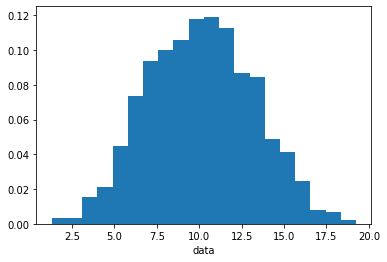

In [238]:
#sample_data = df.pmra
N = 1000
#data = np.random.normal(loc=100.0, scale=3.0, size=N)
data = np.random.normal(loc=10, scale=3.0, size=N) + np.random.uniform(-1,1,N)#np.random.random(N)

#plt.figure(figsize=(8,4))
bin_heights, bin_borders, _ = plt.hist(data, bins='auto',range=(min(data),max(data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
#x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
#plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('data')
print(np.mean(data),np.std(data))

In [248]:
def log_likelihood_1(params, x):
    std, mu = params
    #x = sample_data
    Ac = -0.5*((x - mu)/std)**2
    y = 1/(np.sqrt(2 * np.pi * std**2)) * np.exp( Ac )
    # Calculate negative log likelihood
    #nll = -np.sum(np.log(y))
    return np.sum(np.log(y))

def log_likelihood(params, x):
    std, mu = params
    # Calculate negative log likelihood
    N = len(x)
    return -0.5 * N * np.log(2 * np.pi) - N * np.log(std) - 0.5* np.sum(((x - mu)/std)**2)

def log_prior(params):
    std, mu = params
    if 0.0 < std < 10.0 and 0.0 < mu < 20.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_1(params, x)

In [249]:
sample_data = data#df.pmra
std, mu = np.std(sample_data), np.mean(sample_data)
initparams = [std, mu]
print(initparams)
print(log_likelihood(initparams, sample_data))
print(log_likelihood_1(initparams, sample_data))
print(log_prior(initparams))
print(log_probability(initparams, sample_data))

nll = lambda *args: -log_likelihood_1(*args)

results = minimize(nll, initparams, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results.x

[3.101154919461221, 10.110194299380625]
-2550.7131299794255
-2550.7131299794255
0.0
-2550.7131299794255


array([ 3.10115492, 10.1101943 ])

In [250]:
def Metropolis(params, data, a = 0.1, NSteps = int(3e4)):
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    #x[0] = [np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in tqdm(range(1, NSteps)):
        std = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        mu = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
#         sc = x[i-1,1] + np.random.uniform(-1,1)
        
        #present = log_likelihood(params) + log_prior(params)
        present = log_probability(params, data)
        #future = log_likelihood([std, mu]) + log_prior([std, mu])
        future = log_probability([std, mu], data)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = std
            x[i,1] = mu
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [251]:
initparams = results.x
MCMC = Metropolis(initparams, sample_data, 0.1, 100000)

100%|██████████| 99999/99999 [00:13<00:00, 7584.24it/s]


Minimize: [ 3.10115492 10.1101943 ]
MCMC:     [ 3.10604073 10.108641  ]


Text(0.5, 0, 'step number')

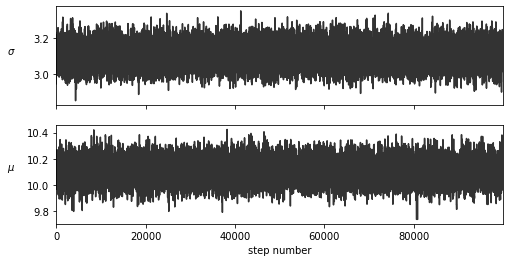

In [252]:
params_mcmc = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

fig, axes = plt.subplots(len(params_mcmc), figsize=(8, 4), sharex=True)
labels = ["$\sigma$", "$\mu$"]
for i in range(len(params_mcmc)):
    ax = axes[i]
    ax.plot(MCMC[:,i], 'k', alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

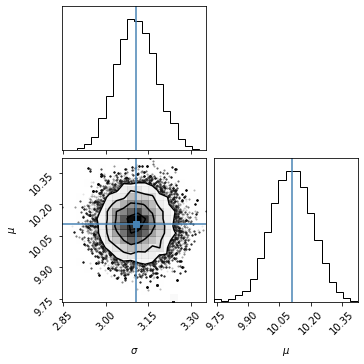

In [253]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$\sigma$", "$\mu$"]

figure = corner.corner(MCMC, labels=labels, truths=truths)

(86964, 20)


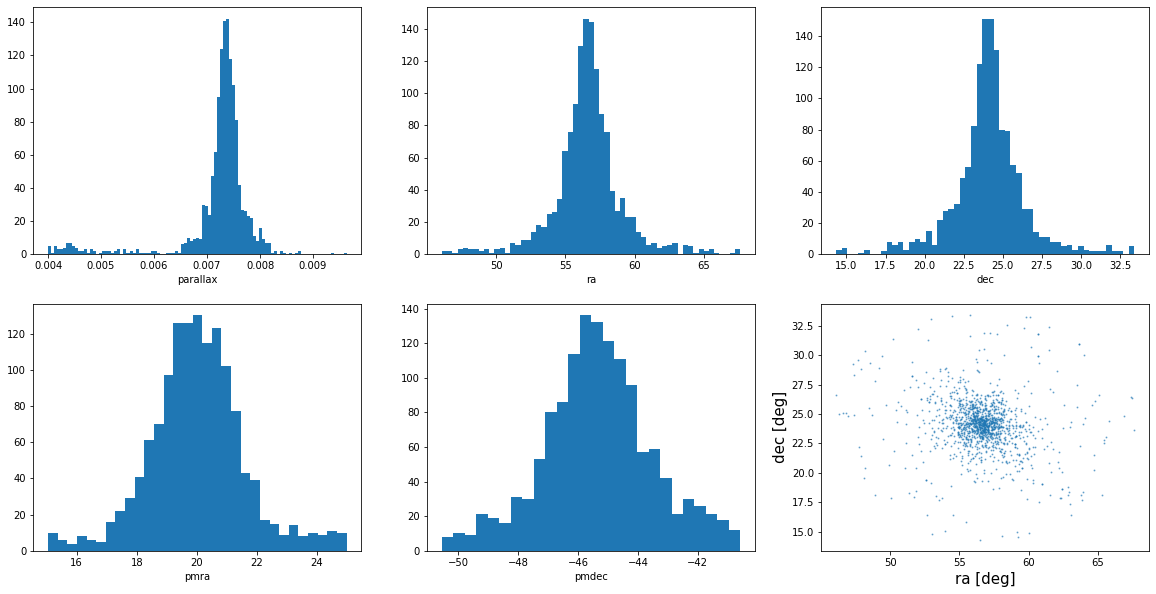

1359


In [254]:
df = pd.read_csv('./pleiades_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
#c_pm = (df['pmra'] > -30) & (df['pmra'] < 0) & (df['pmdec'] > 0) & (df['pmdec'] < 30)
#df = df[c_pm]
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

#plt.figure(figsize=(20,10))

#plt.subplot(2,3,1)
#plt.hist(df.parallax,bins='auto')
#plt.xlim(0.002,0.01)

#plt.subplot(2,3,2)
#plt.hist(df.ra,bins='auto')

#plt.subplot(2,3,3)
#plt.hist(df.dec,bins='auto')

#plt.subplot(2,3,4)
#plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)

#plt.subplot(2,3,5)
#plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)

#plt.subplot(2,3,6)
#plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
#plt.xlabel("ra [deg]",  fontsize = 15)
#plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)

#plt.show()

mu_alpha, mu_delta = 19.997, -45.548
rango = 5
c_pm=(df['pmra']>mu_alpha-rango)&(df['pmra']<mu_alpha+rango)&\
                        (df['pmdec']>mu_delta-rango)&(df['pmdec']<mu_delta+rango)
c_p = (df['parallax'] > 0.004) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
#lt.xlim(v_min,v_max)
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

print(len(df))

In [235]:
# nwalkers, ndim = 250, 2
# #p0 = [results_pmra.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# p0 = results_pmra.x * np.random.randn(nwalkers, ndim)
# #p0 = [np.random.rand(ndim) for i in range(nwalkers)]

# import emcee
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[sample_data])
# pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)

# #samples = sampler.chain
# samples = sampler.get_chain()
# labels = ["$\sigma$", "$\mu$"]
# fig, axes = plt.subplots(ndim, figsize=(8, 4), sharex=True)
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.2)
#     #ax.plot(pos[:, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i], rotation=0)
#     ax.yaxis.set_label_coords(-0.1, 0.5)
# axes[-1].set_xlabel("step number")

# tau = sampler.get_autocorr_time()
# print(tau)
# flat_samples = sampler.get_chain(discard=50, flat=True)
# print(flat_samples.shape)

# maxprob_indice = np.argmax(prob)
# sigma_fit, mean_fit = pos[maxprob_indice]

# import corner
# fig = corner.corner(flat_samples, labels=labels, truths=[sigma_fit, mean_fit])

# Two Gaussian functions

In [262]:
def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

In [265]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

nll = lambda *args: -log_likelihood(*args)

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-2574.8128046620714
0.0
-2574.8128046620714


array([ 0.61805723,  1.00640763,  2.23579727, 19.93378179, 20.14465459])

In [266]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

nll = lambda *args: -log_likelihood(*args)

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-2808.1427719609346
0.0
-2808.1427719609346


array([  0.24741074,   0.82975759,   2.06973124, -45.48281079,
       -45.27869664])

Text(0.5, 0, 'pmdec')

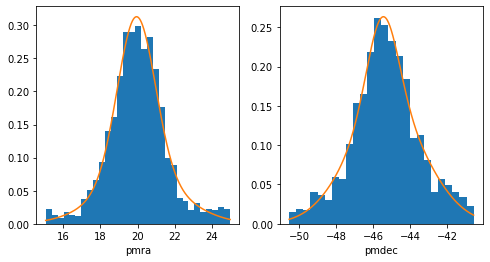

In [267]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [268]:
def Metropolis(params, data, a = 0.1, NSteps = int(3e4)):
    
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    #x[0] = [np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in tqdm(range(1,NSteps)):
        #a = 0.1
        nc = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        sc = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        sf = x[i-1,2] + a * np.random.normal(loc=0, scale=1.0)
        mu_c = x[i-1,3] + a * np.random.normal(loc=0, scale=1.0)
        mu_f = x[i-1,4] + a * np.random.normal(loc=0, scale=1.0)
        
        present = log_probability(params, data)
        
        future = log_probability([nc,sc,sf,mu_c,mu_f], data)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand() 
        
        if alpha > g:
            x[i,0] = nc
            x[i,1] = sc
            x[i,2] = sf
            x[i,3] = mu_c
            x[i,4] = mu_f
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [288]:
sample_data = df.pmra
initparams = results_pmra.x
MCMC = Metropolis(initparams, sample_data, 0.1, 100000)

100%|██████████| 99999/99999 [06:05<00:00, 273.32it/s]


Minimize: [ 0.61805723  1.00640763  2.23579727 19.93378179 20.14465459]
MCMC:     [ 0.62235425  1.01370064  2.22579735 19.93633722 20.14236696]


Text(0.5, 0, 'step number')

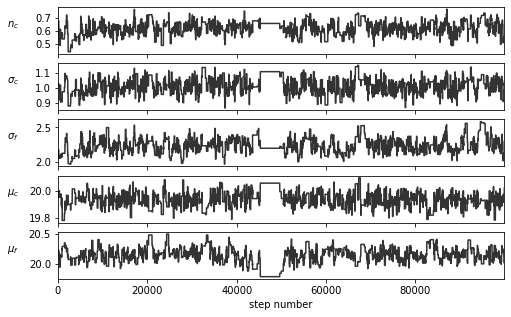

In [289]:
params_mcmc_pmra = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

fig, axes = plt.subplots(len(params_mcmc_pmra), figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(len(params_mcmc_pmra)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

In [290]:
q1 = np.quantile(MCMC, q=[0.16,0.84],axis=0)

errorsup = q1[1] -params_mcmc_pmra
errorinf = params_mcmc_pmra - q1[0]
print(errorsup)
print(errorinf)
print(results_pmra.x)

[0.04689173 0.05885635 0.12691922 0.05641653 0.12498097]
[0.05625425 0.05290106 0.10077424 0.05210766 0.12937394]
[ 0.61805723  1.00640763  2.23579727 19.93378179 20.14465459]


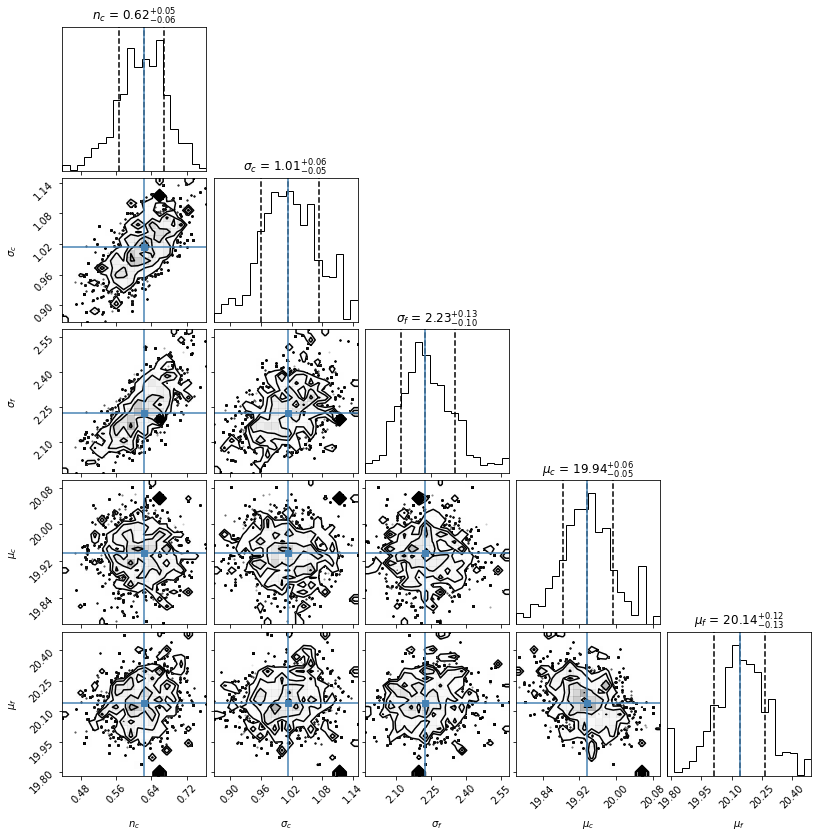

In [295]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]

figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

In [297]:
sample_data = df.pmdec
initparams = results_pmdec.x
MCMC = Metropolis(initparams, sample_data, 0.1, 100000)

100%|██████████| 99999/99999 [06:08<00:00, 271.69it/s]


Minimize: [  0.24741074   0.82975759   2.06973124 -45.48281079 -45.27869664]
MCMC:     [  0.25664287   0.85782798   2.07682993 -45.47439425 -45.27787683]


Text(0.5, 0, 'step number')

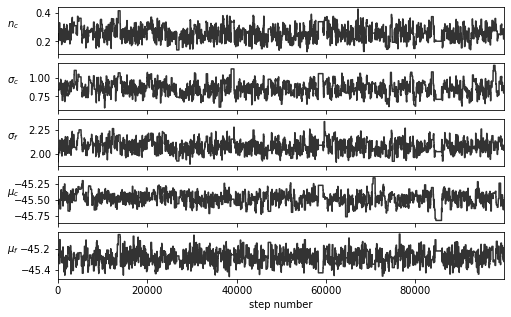

In [298]:
params_mcmc_pmdec = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

fig, axes = plt.subplots(len(params_mcmc_pmdec), figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(len(params_mcmc_pmdec)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

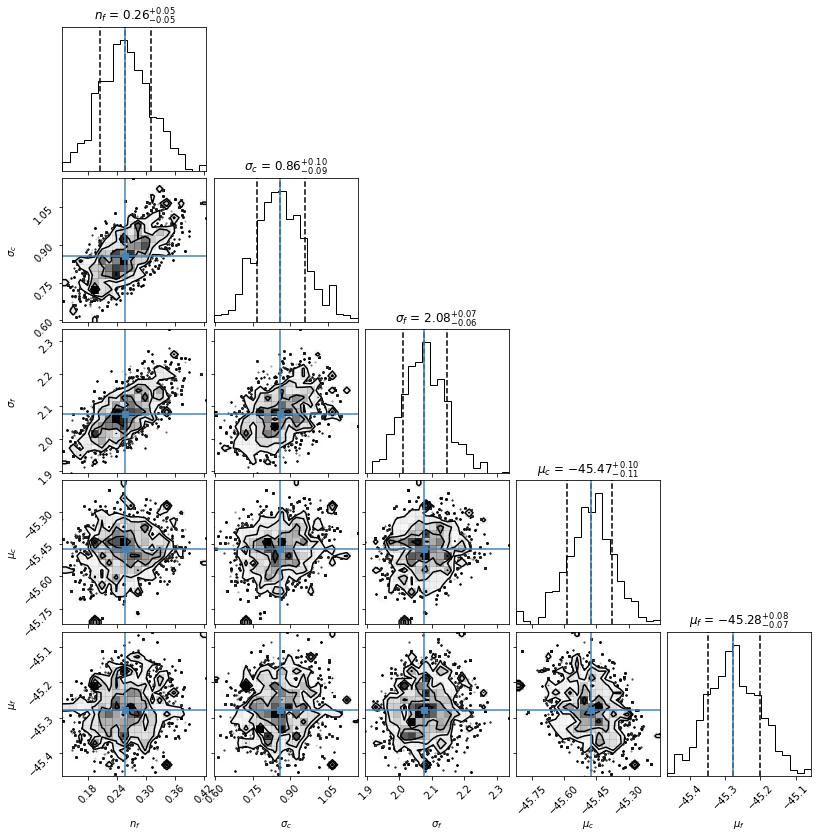

In [299]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$n_f$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]

figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

Text(0.5, 0, 'pmdec')

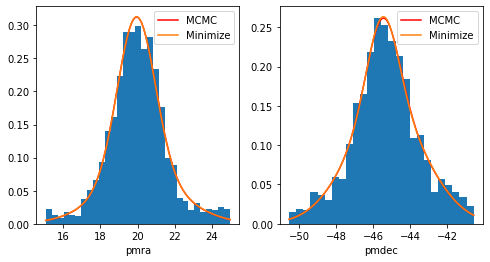

In [301]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize')
plt.legend()
plt.xlabel('pmdec')

# 2D Gaussian function

In [316]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [317]:
def Metropolis(params, X, Y, a = 0.1, NSteps = int(3e4)):
    
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    for i in tqdm(range(1, NSteps)):
        nc = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        s = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        sx = x[i-1,2] + a * np.random.normal(loc=0, scale=1.0)
        sy = x[i-1,3] + a * np.random.normal(loc=0, scale=1.0)
        rho = x[i-1,4] + a * np.random.normal(loc=0, scale=1.0)
        mu_xc = x[i-1,5] + a * np.random.normal(loc=0, scale=1.0)
        mu_yc = x[i-1,6] + a * np.random.normal(loc=0, scale=1.0)
        mu_xf = x[i-1,7] + a * np.random.normal(loc=0, scale=1.0)
        mu_yf = x[i-1,8] + a * np.random.normal(loc=0, scale=1.0)
        
        present = log_probability(params, X, Y)
        
        future = log_probability([nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf], X, Y)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = nc
            x[i,1] = s
            x[i,2] = sx
            x[i,3] = sy
            x[i,4] = rho
            x[i,5] = mu_xc
            x[i,6] = mu_yc
            x[i,7] = mu_xf
            x[i,8] = mu_yf
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [318]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 1.0064076342822907, 2.2357972683432354, 2.0697312351644546, -0.2693736045153358, 19.93378179337074, -45.48281079423144, 20.14465459498267, -45.27869663918549]
-5208.424957293917
0.0
-5208.424957293917


array([  0.45725415,   0.9604988 ,   1.98815784,   2.32863473,
        -0.30832104,  19.90156332, -45.40793731,  20.10917793,
       -45.26290336])

In [327]:
x = df.pmra
y = df.pmdec
initparams = results.x
MCMC = Metropolis(initparams, x, y, 0.01, 100000)

100%|██████████| 99999/99999 [12:11<00:00, 136.79it/s] 


Minimize: [  0.45725415   0.9604988    1.98815784   2.32863473  -0.30832104
  19.90156332 -45.40793731  20.10917793 -45.26290336]
MCMC:     [  0.46856841   0.96452436   2.0054117    2.35181336  -0.30802723
  19.90098703 -45.41140076  20.09889009 -45.27173072]


Text(0.5, 0, 'step number')

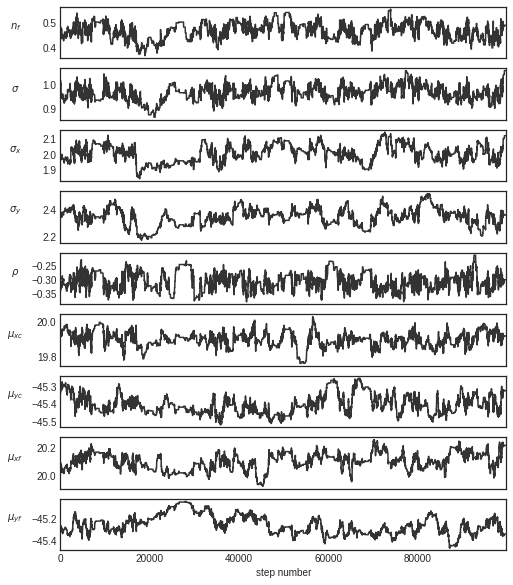

In [358]:
params_mcmc = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

fig, axes = plt.subplots(len(params_mcmc), figsize=(8, 10), sharex=True)
labels = ["$n_f$", "$\sigma$", "$\sigma_x$", "$\sigma_y$", "$\\rho$",
          "$\mu_{xc}$", "$\mu_{yc}$", "$\mu_{xf}$", "$\mu_{yf}$"]
for i in range(len(params_mcmc)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

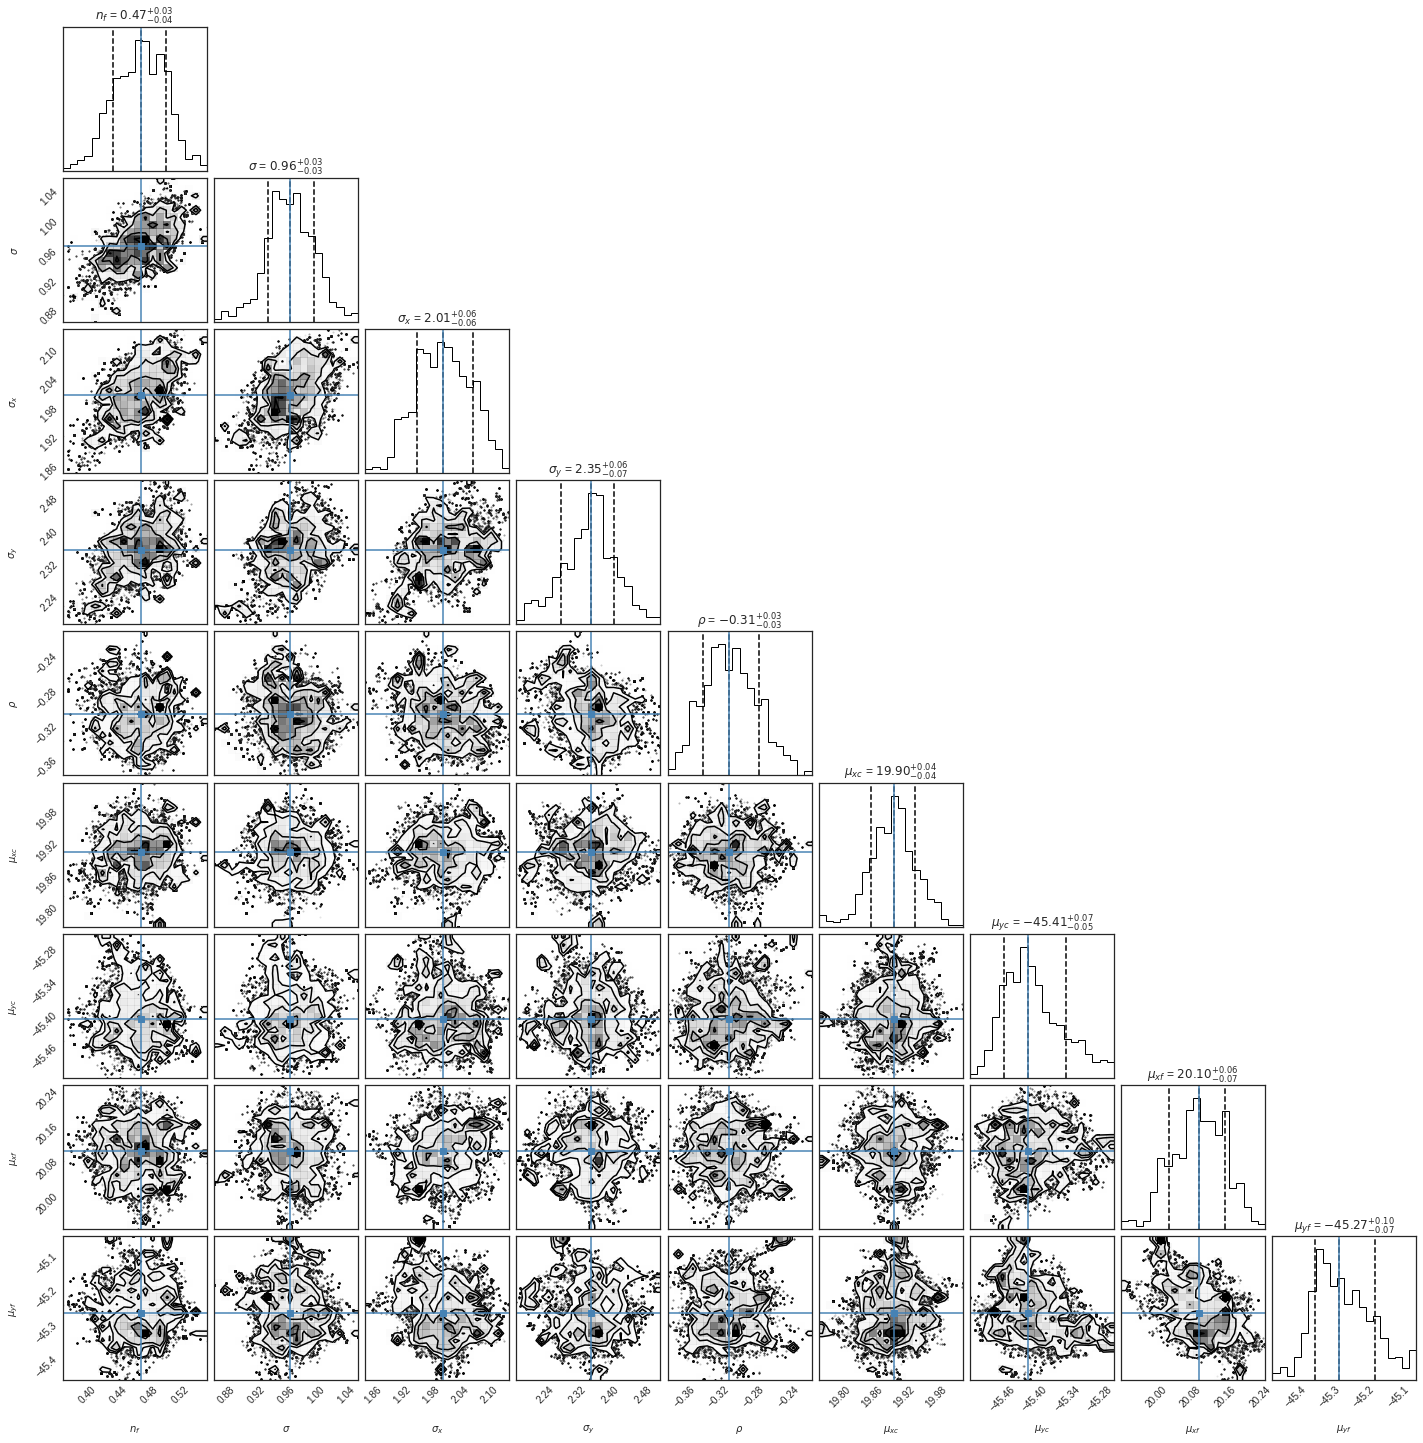

In [359]:
truths = np.percentile(MCMC ,50, axis=0)
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
labels = ["$n_f$", "$\sigma$", "$\sigma_x$", "$\sigma_y$", "$\\rho$",
          "$\mu_{xc}$", "$\mu_{yc}$", "$\mu_{xf}$", "$\mu_{yf}$"]
figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

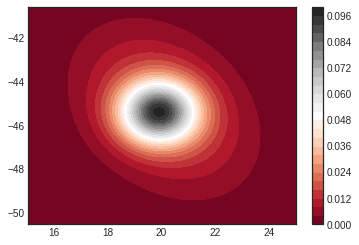

In [356]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z


X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

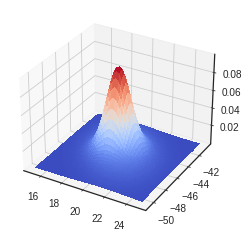

In [357]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

0.8469180807182665


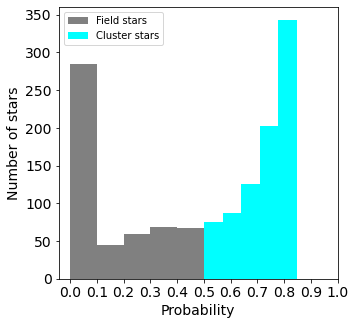

In [330]:
nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths

def probabilidad_circ(xy, nf, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return (1 - nf) * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nf, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return nf * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nf, s, mu_xc, mu_yc)
param_elip_prob = (nf, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
#print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)
print(max(prob))
plt.figure(figsize=(5,5))
plt.hist(prob, bins=5,range=[min(prob), 0.5], label='Field stars',color='gray')
plt.hist(prob[(prob > 0.5)], bins=5,color='cyan',label='Cluster stars')
#N, bins, patches = plt.hist(prob, bins=10,range=[min(prob), max(prob)], label='Field stars',color='gray')
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.axvline(x = 0.5, color = 'black', label = 'Cut off', linestyle = '--')
plt.legend()
#plt.savefig('./results/pleiades_probabilities.jpg',bbox_inches = "tight")
plt.show()

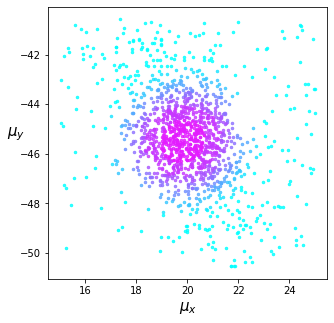

In [331]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [332]:
df['probability'] = prob
m45_members = df[members]
#m45_members.to_csv('./pleiades_PMmodel.csv')
print(len(m45_members))
m45_members

833


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
175,63449521800719488,55.773982,0.079372,21.030220,0.058686,0.007661,0.000102,19.368667,0.119068,-46.283156,...,17.138874,2.743944,15.843201,15.539463,19.031832,7.887697,0.000000,0.000000,0.984827,0.796942
371,63507860340462208,56.593062,0.223397,21.088765,0.156204,0.007590,0.000266,20.472016,0.275824,-46.552291,...,18.534664,1.763879,17.123377,11.337543,20.782875,6.528066,0.000000,0.000000,0.999825,0.725703
467,63527827643105408,56.532550,0.173796,21.345159,0.133183,0.007235,0.000185,19.009062,0.237064,-45.063595,...,18.706327,1.449828,17.319443,10.996151,20.768375,5.878046,0.000000,0.000000,0.955010,0.795410
469,65588484235454592,58.268967,0.013425,22.801153,0.008666,0.007293,0.000015,19.036700,0.017368,-45.560948,...,13.100869,73.891630,12.250756,178.715670,13.850247,130.469680,6.250218,0.944959,1.044438,0.813259
484,65589137070475264,58.315505,0.035570,22.870487,0.023680,0.007730,0.000039,19.499144,0.048635,-47.304899,...,15.532084,6.844055,14.332067,22.692156,17.030619,12.360832,-8.788499,9.603173,1.087538,0.558686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74327,119707889661936768,52.566314,0.031083,28.581672,0.022374,0.007394,0.000036,20.277727,0.036524,-47.068419,...,15.080872,18.677797,13.937094,39.469643,16.435133,16.455122,-4.663462,11.072157,1.093844,0.610867
74685,119776604841920896,53.630066,0.091859,28.841984,0.073737,0.007232,0.000101,20.992627,0.114394,-44.524271,...,17.389180,3.409288,16.075298,18.830961,19.325594,12.794014,0.000000,0.000000,1.014917,0.700481
79154,122022121119845120,47.906911,0.221332,28.792018,0.182254,0.004251,0.000256,19.314525,0.348698,-43.723746,...,18.650220,1.511869,17.374552,11.072809,20.266167,6.969432,0.000000,0.000000,1.037522,0.554760
79978,120566642602294144,51.571820,0.085602,29.402625,0.058282,0.006924,0.000095,21.107899,0.112349,-43.942702,...,16.907210,2.888820,15.617982,18.219112,18.731787,10.021989,0.000000,0.000000,1.021745,0.542430


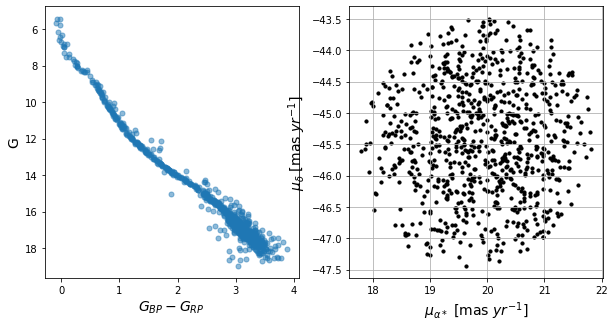

In [333]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
#plt.plot(pleiades['bp'] - pleiades['rp'], pleiades['g'],color='black',marker='.',linestyle='None',markersize=1,alpha=0.5)
plt.plot(m45_members['bp'] - m45_members['rp'], m45_members['g'],marker='o',linestyle='None',markersize=5,alpha=0.5)
#plt.text(4.2, 5.5, 'Pleiades',fontsize=15)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
plt.gca().invert_yaxis()
#plt.savefig('./images_pm/pleiades_CMD_pm.jpg',bbox_inches = "tight")

plt.subplot(1,2,2)
#plt.plot(m44['pmra'], m44['pmdec'], color = 'black', marker = '.',linestyle = 'None', markersize = 1, alpha = 1)
plt.scatter(m45_members['pmra'], m45_members['pmdec'], color = 'black', marker = 'o', s = 10, alpha = 1)
plt.xlabel('$\mu_{\\alpha *}$ [mas $yr^{-1}$]',  fontsize = 14)
plt.ylabel("$\mu_{\delta}$ [mas $yr^{-1}$]",  fontsize = 14)
#plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5],fontsize=14)
#plt.xticks([17, 18, 19, 20, 21],fontsize=14)
plt.grid()
#plt.savefig('./images_pm/pleiades_vpd_pm.jpg',bbox_inches = "tight")
plt.show()

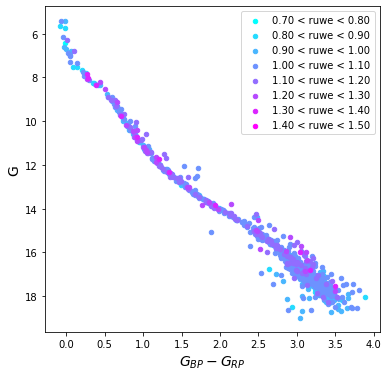

In [334]:
loop = np.arange(0.7, 1.5, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]
plt.figure(figsize=(6,6))
for i,c in zip(loop, colors):
  cond = (m45_members.ruwe >= i) & (m45_members.ruwe < i + 0.1)
  color, g_mag = m45_members['bp'][(cond)]-m45_members['rp'][(cond)], m45_members['g'][(cond)]
  plt.scatter(color, g_mag,marker='o',color=c,s=20,alpha=1,label='{:.2f} < ruwe < {:.2f}'.format(i,i+0.1))
plt.gca().invert_yaxis()
plt.legend(fontsize = 10)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
#plt.savefig('./results/pleiades_cmd_ruwe.jpg',bbox_inches = "tight")
plt.show()

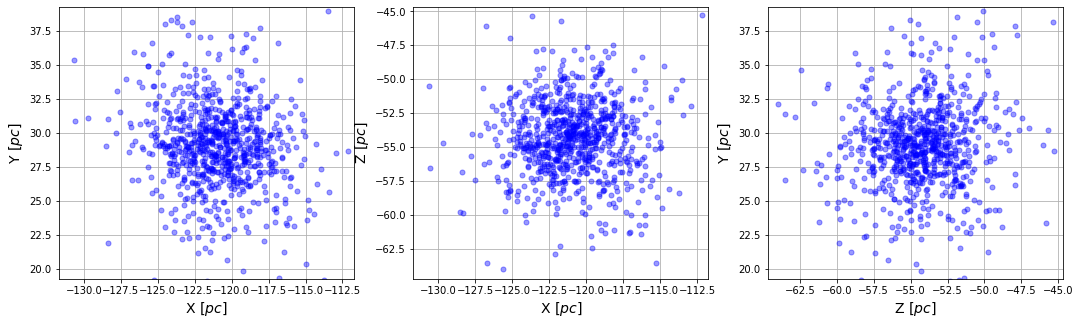

In [335]:
import astropy.units as u
import astropy.coordinates as apycoords

df_test = m45_members

ra_ = df_test['ra'] *u.deg
dec_ = df_test['dec'] *u.deg
distance_ = np.array(1/df_test['parallax']) *u.pc

c = apycoords.SkyCoord(ra=ra_,dec=dec_,distance=distance_,frame='icrs')
#print("(X,Y,Z) in (kpc,kpc,kpc)")
#print("\t",c.galactic.cartesian)
x = c.galactic.cartesian.x
y = c.galactic.cartesian.y
z = c.galactic.cartesian.z

xp = np.mean(x.to_value())
yp = np.mean(y.to_value())
zp = np.mean(z.to_value())
value = 10

%matplotlib inline
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(x, y,color='blue',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,2)
plt.plot(x, z,color='blue',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(zp - value,zp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Z $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,3)
plt.plot(z, y,color='blue',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(zp - value,zp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("Z $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()
#plt.savefig('./results/distribucion_espacial_test.jpg')
plt.show()